## IT Merger and Acquisition Model Development

Extensive data preparation is carried out to handle the following.
1. Data Cleaning
2. Backfill missing data
3. Removing companies that don't have significant missing data
4. Outlier detection and removal

In this notebook, we will use this updated data to experiment with machine learning models. 

In [1]:
# Import the required python packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd

In [2]:
# Load the final data
data = pd.read_csv("../data/IT_MA_Final_original_data_v1.csv")

In [3]:
data.head(5)

,Company Name,Inc Year,Delete Flag,Acquisition Flag,2000-Return on equity,2001-Return on equity,2002-Return on equity,2003-Return on equity,2004-Return on equity,2005-Return on equity,...,2012-Log Total assets,2013-Log Total assets,2014-Log Total assets,2015-Log Total assets,2016-Log Total assets,2017-Log Total assets,2018-Log Total assets,2019-Log Total assets,2020-Log Total assets,2021-Log Total assets
0,3D P L M Global Services Pvt. Ltd.,2014.0,TBAG50L80,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.496508,5.494295,5.747799,6.224954,6.404402,7.014005,7.117124,7.117124
1,3I Infotech Consultancy Services Ltd.,2007.0,TBAG50L80,No,NaN,NaN,NaN,NaN,NaN,NaN,...,6.189700,6.045716,6.160363,6.282827,6.274950,6.240666,5.802420,5.823933,5.913503,5.913503
2,3I Infotech Ltd.,1993.0,TBAG80,Yes,NaN,9.70,8.05,6.39,34.85,23.15,...,10.713971,10.711961,10.527960,10.244332,10.238484,10.180816,10.208458,10.245313,10.202629,10.202629
3,63 Moons Technologies Ltd.,1988.0,TBAG80,No,23.59,-25.16,1.39,31.65,10.20,32.20,...,10.491294,10.369041,10.444343,10.450484,10.464845,10.347041,10.308789,10.268433,10.255418,10.255418
4,A B B Global Inds. & Services Pvt. Ltd.,2001.0,TBAG50L80,Yes,NaN,NaN,NaN,NaN,NaN,NaN,...,8.618070,8.618070,8.618070,8.618070,8.618070,8.618070,8.618070,8.618070,8.618070,8.618070


In [4]:
# This is the target variable that will be predicted by the model.
Y_column  = "Acquisition Flag"
#non_data_cols = ['Acquired','Year of acquisition']
non_data_cols = ['Acquisition Flag','Delete Flag', 'Inc Year','Company Name']

In [5]:
print(f"Total companies : {data.shape[0]}")
print(f"Companies that have all data for all years : {data.dropna().shape[0]}")

Total companies : 462
Companies that have all data for all years : 74


In [6]:
print(f"Total Acquired companies in the dataset : {data[data[Y_column]=='Yes'].shape[0]}")

Total Acquired companies in the dataset : 86


In [7]:
year_count = {}
year_cols = {}
cols = data.columns
for year in range(2000, 2022):
    year_count[f"{year}-"] = 0
    year_cols[f"{year}-"] = []
    for col in data.columns:
        if f"{year}-" in col:
            year_count[f"{year}-"] +=1
            year_cols[f"{year}-"].append(col)

print(year_count)

{'2000-': 17, '2001-': 17, '2002-': 17, '2003-': 17, '2004-': 17, '2005-': 17, '2006-': 17, '2007-': 17, '2008-': 17, '2009-': 17, '2010-': 17, '2011-': 17, '2012-': 17, '2013-': 17, '2014-': 17, '2015-': 17, '2016-': 17, '2017-': 17, '2018-': 17, '2019-': 17, '2020-': 17, '2021-': 18}


In [8]:
# List of input variables for building the model.
dims = year_cols["2015-"]
dims = [dim.replace("2015-","") for dim in dims]
dims

['Return on equity',
 'Return on sales',
 'Return on capital employed',
 'Net profit margin',
 'Return on total assets',
 'Free Cash Flow Return',
 'Quick ratio (times)',
 'Current ratio (times)',
 'Sales Growth Over Past Year',
 'Equity turnover',
 'Invested Capital Turnover',
 'Pre Tax Margin',
 'Debt to Asset ratio',
 'Debt to equity ratio (times)',
 'Interest Coverage Ratio',
 'Log Sales',
 'Log Total assets']

In [9]:
#selected_dims=['Return on equity','Return on sales','Current ratio (times)'
#                  ,'Sales Growth Over Past Year','Equity turnover','Net profit margin','Log Sales',
#                  'Debt to equity ratio (times)','Interest Coverage Ratio','Free Cash Flow Return']
selected_dims = dims

In [10]:
# Number of acquired companies in the data
df_ma = data[data[Y_column]=='Yes']
df_ma.shape

(86, 379)

In [11]:
# Basic verification of nulls to ensure data quality
row_null = df_ma.isnull().sum(axis=1).tolist()
df_ma['null_count'] = row_null
print(df_ma[df_ma['null_count']==0].shape)
dfma = df_ma[df_ma['null_count']<400]
print(dfma.shape)

(34, 380)
(86, 380)


/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/1318280318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma['null_count'] = row_null


In [12]:
# Not Acquired
df_non_ma = data[data[Y_column]=='No']
print(df_non_ma.shape)
row_null = df_non_ma.isnull().sum(axis=1).tolist()
df_non_ma['null_count'] = row_null
dfnonma = df_non_ma[df_non_ma['null_count']<400]
print(dfnonma.shape)

(376, 379)
(376, 380)


/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/2971914881.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_ma['null_count'] = row_null


In [13]:
# Non Acquired companies
dfnonma.shape

(376, 380)

In [14]:
# Acquired
dfma.shape

(86, 380)

In [15]:
df = pd.concat([dfnonma, dfma])
df = df.sort_values(['Company Name']).reset_index(drop=True)
df.head(1)

,Company Name,Inc Year,Delete Flag,Acquisition Flag,2000-Return on equity,2001-Return on equity,2002-Return on equity,2003-Return on equity,2004-Return on equity,2005-Return on equity,...,2013-Log Total assets,2014-Log Total assets,2015-Log Total assets,2016-Log Total assets,2017-Log Total assets,2018-Log Total assets,2019-Log Total assets,2020-Log Total assets,2021-Log Total assets,null_count
0,3D P L M Global Services Pvt. Ltd.,2014.0,TBAG50L80,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.496508,5.494295,5.747799,6.224954,6.404402,7.014005,7.117124,7.117124,250


This is time series data repeated at year level. To apply RF model, we will convert into features that will retain this information without too much loss. We do extensive feature engineering here. 

For example, "Return on equity" is an input variable with data for 21 years.

In [16]:
def count_above_mean(x):
    """
    Returns the number of values in x that are higher than the mean of x

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = np.mean(x)
    return np.where(x > m)[0].size

def count_below_mean(x):
    """
    Returns the number of values in x that are lower than the mean of x

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    m = np.mean(x)
    return np.where(x < m)[0].size

def last_location_of_maximum(x):
    """
    Returns the relative last location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    x = np.asarray(x)
    return 1.0 - np.argmax(x[::-1]) / len(x) if len(x) > 0 else np.NaN

def first_location_of_maximum(x):
    """
    Returns the first location of the maximum value of x.
    The position is calculated relatively to the length of x.

    :param x: the time series to calculate the feature of
    :type x: numpy.ndarray
    :return: the value of this feature
    :return type: float
    """
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.argmax(x) / len(x) if len(x) > 0 else np.NaN

In [17]:
# Feature Extraction
features_df = pd.DataFrame()
for dim in selected_dims:
    cols = [f"{str(year)}-{dim}" for year in range(2000, 2022)]
    df_dim = df[cols]
    df_dim = df_dim.astype(float)
    features_df[f"{dim}__max"] = df_dim.max(axis=1)
    features_df[f"{dim}__min"] = df_dim.min(axis=1)
    features_df[f"{dim}__variance"] = df_dim.var(axis=1)
    features_df[f"{dim}__std"] = df_dim.std(axis=1)
    features_df[f"{dim}__sum"] = df_dim.sum(axis=1)
    features_df[f"{dim}__mean"] = df_dim.mean(axis=1)
    features_df[f"{dim}__skew"] = df_dim.skew(axis=1)
    features_df[f"{dim}__kurtosis"] = df_dim.kurtosis(axis=1)
    features_df[f"{dim}__cnt_above_mean"] = df_dim.apply(count_above_mean, axis=1)
    features_df[f"{dim}__cnt_below_mean"] = df_dim.apply(count_below_mean, axis=1)
    #features_df[f"{dim}__first_max"] = df_dim.apply(first_location_of_maximum, axis=1)
    #features_df[f"{dim}__last_max"] = df_dim.apply(last_location_of_maximum, axis=1)

features_df[Y_column] = pd.Categorical(df[Y_column]).codes

/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__max"] = df_dim.max(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__min"] = df_dim.min(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__max"] = df_dim.max(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__min"] = df_dim.min(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__max"] = df_dim.max(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[f"{dim}__min"] = df_dim.min(axis=1)
/var/folders/vk/c62whj215n12n7wh_5z7d4w00000gn/T/ipykernel_1128/500522213.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

In [18]:
features_df = features_df.apply(lambda x: x.fillna(x.mean()), axis=0)
features_df = features_df.dropna()
print(features_df.shape)
features_df.head()

(462, 171)


,Return on equity__max,Return on equity__min,Return on equity__variance,Return on equity__std,Return on equity__sum,Return on equity__mean,Return on equity__skew,Return on equity__kurtosis,Return on equity__cnt_above_mean,Return on equity__cnt_below_mean,...,Log Total assets__min,Log Total assets__variance,Log Total assets__std,Log Total assets__sum,Log Total assets__mean,Log Total assets__skew,Log Total assets__kurtosis,Log Total assets__cnt_above_mean,Log Total assets__cnt_below_mean,Acquisition Flag
0,92.94,19.84,843.110214,29.036360,355.890,50.841429,0.448024,-1.385823,3,4,...,3.496508,1.468234,1.211707,48.616212,6.077027,-1.531690,2.669587,5,3,0
1,80.00,-6.17,484.391121,22.008887,177.820,12.701429,2.572869,7.167997,3,11,...,4.859812,0.152983,0.391131,84.450963,6.032212,-2.222959,6.355581,9,5,0
2,149.21,-2772.61,438650.809600,662.307187,-3912.195,-186.295000,-3.534348,12.796227,19,2,...,8.039157,0.806820,0.898232,205.947448,9.807021,-1.157604,-0.169788,15,6,1
3,115.26,-25.16,778.296200,27.897960,348.260,15.830000,2.313777,7.469315,8,14,...,5.657040,3.026143,1.739581,202.654923,9.211587,-1.146564,-0.422563,15,7,0
4,40.69,6.33,147.073393,12.127382,222.040,13.877500,1.227033,-0.023996,5,11,...,7.718063,0.064916,0.254785,136.573732,8.535858,-2.764938,7.605073,13,3,1


### Split into Train and Test

In [19]:
X = features_df.drop(columns=[Y_column])
X_train, X_test, y_train, y_test = train_test_split(X, features_df[Y_column], random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f"Training data - No of companies : {X_train.shape[0]}")
print(f"Test data - No of companies : {X_test.shape[0]}")

(346, 170) (116, 170) (346,) (116,)
Training data - No of companies : 346
Test data - No of companies : 116


In [20]:
X_train[X_train.isnull().sum(axis=1) > 0].shape

(0, 170)

In [21]:
X_train.shape

(346, 170)

In [22]:
print(X_train[X_train.isin([np.inf, -np.inf]).sum(axis=1) > 0].shape)
print(X_test[X_test.isin([np.inf, -np.inf]).sum(axis=1) > 0].shape)
#print(X_train[X_train.isin([np.inf, -np.inf]).sum()>0].shape)

(1, 170)
(2, 170)


In [23]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
X_train.shape

(346, 170)

In [24]:
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)
X_test.shape

(116, 170)

In [25]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9224137931034483

Calculate Feature importance

In [26]:
feature_importances = {}
for feature, value in zip(features_df.columns, rf.feature_importances_):
    feature = feature.split("__")[0]
    if feature in feature_importances:
        val_list = feature_importances[feature]
    else:
        val_list = []
    val_list.append(np.round(value,4))
    feature_importances[feature] = val_list

In [27]:
feature_imp = {}
for key in feature_importances.keys():
    feature_imp[key] = np.sum(feature_importances[key])
    
sorted(feature_imp.items(), key=lambda x:x[1], reverse=True)

[('Free Cash Flow Return', 0.39200000000000007),
 ('Invested Capital Turnover', 0.0746),
 ('Log Sales', 0.060300000000000006),
 ('Current ratio (times)', 0.0594),
 ('Log Total assets', 0.0582),
 ('Quick ratio (times)', 0.052099999999999994),
 ('Equity turnover', 0.051899999999999995),
 ('Debt to Asset ratio', 0.0307),
 ('Return on sales', 0.0304),
 ('Pre Tax Margin', 0.0291),
 ('Net profit margin', 0.0285),
 ('Return on total assets', 0.0271),
 ('Return on equity', 0.026800000000000004),
 ('Return on capital employed', 0.026500000000000006),
 ('Sales Growth Over Past Year', 0.0224),
 ('Debt to equity ratio (times)', 0.0157),
 ('Interest Coverage Ratio', 0.014699999999999998)]

In [28]:
test_probs = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)
for prob, pred, actual in zip(test_probs, y_pred, y_test):
    print(prob, pred, actual)

[0.99 0.01] 0 0
[0.84 0.16] 0 0
[1. 0.] 0 0
[0.5 0.5] 0 0
[0.75 0.25] 0 1
[0.5 0.5] 0 1
[0.94 0.06] 0 0
[1. 0.] 0 0
[0.99 0.01] 0 0
[0.38 0.62] 1 1
[0.94 0.06] 0 0
[1. 0.] 0 0
[0.02 0.98] 1 1
[1. 0.] 0 0
[0.91 0.09] 0 0
[0.5 0.5] 0 0
[0.9 0.1] 0 0
[0.37 0.63] 1 1
[0.33 0.67] 1 1
[1. 0.] 0 0
[0.99 0.01] 0 0
[1. 0.] 0 0
[0.99 0.01] 0 0
[0.99 0.01] 0 0
[0.75 0.25] 0 1
[0.78 0.22] 0 0
[0.95 0.05] 0 0
[0.13 0.87] 1 1
[0.85 0.15] 0 0
[0.99 0.01] 0 0
[0.78 0.22] 0 0
[0.99 0.01] 0 0
[0.99 0.01] 0 0
[0.92 0.08] 0 1
[1. 0.] 0 0
[0.3 0.7] 1 1
[0.99 0.01] 0 0
[0.82 0.18] 0 0
[0.92 0.08] 0 0
[0.99 0.01] 0 0
[0.96 0.04] 0 0
[0.56 0.44] 0 1
[0.97 0.03] 0 0
[0.99 0.01] 0 0
[0.21 0.79] 1 0
[0.67 0.33] 0 0
[0.45 0.55] 1 1
[0.95 0.05] 0 0
[0.98 0.02] 0 0
[0.99 0.01] 0 0
[0.12 0.88] 1 1
[1. 0.] 0 0
[0.92 0.08] 0 0
[0.96 0.04] 0 0
[0.99 0.01] 0 0
[0.99 0.01] 0 0
[0.92 0.08] 0 0
[0.82 0.18] 0 0
[0.46 0.54] 1 1
[0.46 0.54] 1 0
[0.11 0.89] 1 1
[0.91 0.09] 0 0
[0.76 0.24] 0 1
[0.98 0.02] 0 0
[0.94 0.06] 0 0
[0

In [29]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, y_pred)

array([[91,  2],
       [ 7, 16]])

/Users/venuraja/pyenvs/general_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


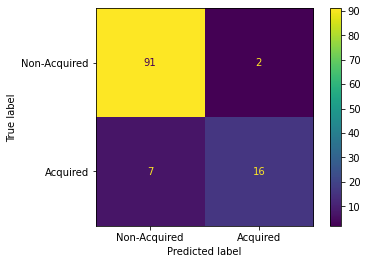

In [30]:
plot_confusion_matrix(rf, X_test, y_test, display_labels=['Non-Acquired','Acquired'])

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Precision : 0.8888888888888888
Recall : 0.6956521739130435
F1 : 0.7804878048780488
Accuracy : 0.9224137931034483


In [32]:
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,7), dpi=1000)
tree.plot_tree(rf.estimators_[5],
               feature_names = features_df.columns, 
               class_names=["Non Acquired","Acquired"],
               max_depth=3,
               fontsize=7,
               filled = True);

# Support Vector Machine model

In [33]:
from sklearn import svm

In [34]:
features_df.isnull().sum()

Return on equity__max               0
Return on equity__min               0
Return on equity__variance          0
Return on equity__std               0
Return on equity__sum               0
                                   ..
Log Total assets__skew              0
Log Total assets__kurtosis          0
Log Total assets__cnt_above_mean    0
Log Total assets__cnt_below_mean    0
Acquisition Flag                    0
Length: 171, dtype: int64

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [37]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
count,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,346.000000,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,...,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02,3.460000e+02
mean,5.133979e-18,5.133979e-18,-5.133979e-18,-5.133979e-18,-5.133979e-18,0.000000,1.476019e-17,2.053592e-17,3.593786e-17,-5.133979e-17,...,-7.700969e-17,3.850484e-17,-4.877280e-17,2.335961e-16,-2.721009e-16,1.540194e-16,4.107183e-17,-1.411844e-17,-1.026796e-16,-1.052466e-16
std,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,...,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00,1.001448e+00
min,-1.864230e-01,-1.707628e+01,-5.686729e-02,-1.023824e-01,-7.237890e+00,-3.710412,-2.801271e+00,-1.707892e+00,-1.282952e+00,-1.484055e+00,...,-2.735935e+00,-2.693633e+00,-5.806370e-01,-1.320123e+00,-1.686879e+00,-2.796852e+00,-3.255252e+00,-1.548564e+00,-1.812708e+00,-1.598327e+00
25%,-8.011219e-02,7.259809e-02,-5.686466e-02,-9.547775e-02,-4.075182e-02,-0.052344,-4.575440e-01,-6.586530e-01,-7.009136e-01,-6.702942e-01,...,-7.208904e-01,-6.708868e-01,-4.921550e-01,-6.733115e-01,-8.356871e-01,-7.968669e-01,-3.987499e-01,-5.209791e-01,-7.848530e-01,-8.052759e-01
50%,-6.995096e-02,1.376235e-01,-5.685395e-02,-8.681979e-02,-1.497308e-02,-0.034297,6.600916e-02,-2.582913e-01,-3.128878e-01,-2.634139e-01,...,2.046153e-02,2.711636e-02,-3.235512e-01,-2.175898e-01,-1.692478e-01,1.098942e-02,6.109675e-02,-3.300034e-01,-1.681404e-01,-2.765748e-01
75%,-4.715745e-02,1.545444e-01,-5.678988e-02,-6.489592e-02,7.102735e-03,-0.015175,6.236510e-01,2.107018e-01,4.631637e-01,7.029269e-01,...,6.789200e-01,6.746463e-01,1.412549e-01,5.274062e-01,7.388692e-01,6.948974e-01,5.553097e-01,9.687905e-03,6.541432e-01,5.164767e-01
max,1.849267e+01,2.931693e-01,1.856962e+01,1.828943e+01,1.678931e+01,18.124623,2.518391e+00,3.509997e+00,2.985331e+00,2.788189e+00,...,3.163026e+00,2.436915e+00,8.128524e+00,5.097049e+00,3.179023e+00,2.945410e+00,4.441996e+00,4.636419e+00,2.709852e+00,4.217384e+00


In [38]:
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score
# instantiate classifier with default hyperparameters
svc=SVC() 
# fit classifier to training set
svc.fit(X_train,y_train)
# make predictions on test set
y_pred=svc.predict(X_test)
# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.90


In [39]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0) 

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred_rbf=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_rbf)))

Model accuracy score with rbf kernel and C=100.0 : 0.9052


In [40]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 

# fit classifier to training set
linear_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=linear_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=1.0 : 0.8879


In [41]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0) 

# fit classifier to training set
poly_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred=poly_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.8621


In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rbf)
cm

array([[88,  5],
       [ 6, 17]])

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision : {precision_score(y_test, y_pred_rbf)}")
print(f"Recall : {recall_score(y_test, y_pred_rbf)}")
print(f"F1 : {f1_score(y_test, y_pred_rbf)}")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rbf)}")

Precision : 0.7727272727272727
Recall : 0.7391304347826086
F1 : 0.7555555555555555
Accuracy : 0.9051724137931034


## XGBoost Model

In [44]:
from xgboost import XGBClassifier

In [45]:
# create model instance
xgb1 = XGBClassifier(n_estimators=5, max_depth=3, learning_rate=1, objective='binary:logistic')

In [46]:
# fit model
xgb1.fit(X_train, y_train)
# make predictions
y_pred = xgb1.predict(X_test)

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[89,  4],
       [ 2, 21]])

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Precision : 0.84
Recall : 0.9130434782608695
F1 : 0.8749999999999999
Accuracy : 0.9482758620689655
